In [1]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr       

catfn='/home/tmerlis/hackathon/xsh24_scream_main.yaml'

combo_cat = intake.open_catalog(catfn)

# 'coarse' is an online coarse-graining of 8 neighboring grid cells ~25km
# xsh24 = X-SHiELD 2024 model version, unpublished
# xsh21 = X-SHiELD 2021 model version, many articles including Cheng et al. 2022 GRL
print (list(combo_cat)) 

['xsh24_coarse', 'xsh24_native', 'xsh21_coarse', 'scream2D_hrly', 'scream_ne120', 'scream_lnd']


In [2]:
# select zoom level and the part of the combined catalog you're interested in
# coarse stores are available at zoom 7 ~50km and lower
zoom_select = 7
ds = combo_cat.xsh24_coarse(zoom=zoom_select).to_dask()
# attach coordinates; otherwise can't use lat and lon and selecting regions or taking a zonal mean won't work
ds = ds.pipe(egh.attach_coords)

# # native stores are available at zoom 10 ~6.4km and lower, fewer variables and all are 2d
# dsn = combo_cat.xsh24_native(zoom=10).to_dask()
# dsn = dsn.pipe(egh.attach_coords)

# we downloaded output from DOE's SCREAM model to stellar
# conceivably, we could add to our local collection of models during the week
# or augment the catalog with observational datasets
# ds_scream = combo_cat.scream_ne120(zoom=zoom_select).to_dask()
# ds_scream = ds_scream.pipe(egh.attach_coords)

/home/xy4043/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [3]:
ds

<xarray.Dataset> Size: 997GB
Dimensions:  (time: 3560, cell: 196608, plev: 31, pfull: 79)
Coordinates:
  * pfull    (pfull) float32 316B 4.514 8.301 12.45 16.74 ... 989.5 994.3 998.3
  * plev     (plev) float32 124B 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * time     (time) object 28kB 2019-10-20 03:00:00 ... 2021-01-07 00:00:00
    crs      int64 8B 0
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
Data variables: (12/38)
    clivi    (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    clt      (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    clwvi    (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    hflsd    (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    hfssd    (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    hur      (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    ...       ...
    uas      (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    va       (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    vas      (time, cell) float32 3GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    wa       (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    wap      (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>
    zg       (time, plev, cell) float32 87GB dask.array<chunksize=(24, 8, 196608), meta=np.ndarray>

In [4]:
def worldmap(var, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)


In [5]:
'''
%%time
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

years = [2019, 2020, 2021]
djf_means = {}

# 1) compute each DJF mean if data exist
for yr in years:
    start = f"{yr}-12-01"
    end   = f"{yr+1}-02-28"
    z500 = ds.zg.sel(plev=500).sel(time=slice(start, end))
    if z500.sizes['time'] > 0:
        djf_means[yr] = z500.mean(dim='time')
    else:
        print(f"skipping DJF {yr}–{yr+1}: no data")

if not djf_means:
    raise ValueError("No DJF seasons found in your dataset!")

# 2) make a multi‐panel map
n = len(djf_means)
proj = ccrs.Robinson(central_longitude=0)
fig, axes = plt.subplots(1, n, figsize=(5*n, 4),
                         subplot_kw={'projection': proj},
                         constrained_layout=True)

# ensure axes is iterable
if n == 1:
    axes = [axes]

for ax, (yr, mean_z) in zip(axes, djf_means.items()):
    ax.set_global()
    pcm = egh.healpix_show(mean_z, ax=ax)
    ax.set_title(f"DJF {yr}–{yr+1} Z₅₀₀ Mean")

# shared colorbar
fig.colorbar(pcm, ax=axes, orientation='vertical',
             pad=0.05, shrink=0.8, label='m')

plt.show()
'''

'\n%%time\nimport cartopy.crs as ccrs\nimport matplotlib.pyplot as plt\n\nyears = [2019, 2020, 2021]\ndjf_means = {}\n\n# 1) compute each DJF mean if data exist\nfor yr in years:\n    start = f"{yr}-12-01"\n    end   = f"{yr+1}-02-28"\n    z500 = ds.zg.sel(plev=500).sel(time=slice(start, end))\n    if z500.sizes[\'time\'] > 0:\n        djf_means[yr] = z500.mean(dim=\'time\')\n    else:\n        print(f"skipping DJF {yr}–{yr+1}: no data")\n\nif not djf_means:\n    raise ValueError("No DJF seasons found in your dataset!")\n\n# 2) make a multi‐panel map\nn = len(djf_means)\nproj = ccrs.Robinson(central_longitude=0)\nfig, axes = plt.subplots(1, n, figsize=(5*n, 4),\n                         subplot_kw={\'projection\': proj},\n                         constrained_layout=True)\n\n# ensure axes is iterable\nif n == 1:\n    axes = [axes]\n\nfor ax, (yr, mean_z) in zip(axes, djf_means.items()):\n    ax.set_global()\n    pcm = egh.healpix_show(mean_z, ax=ax)\n    ax.set_title(f"DJF {yr}–{yr+1} Z

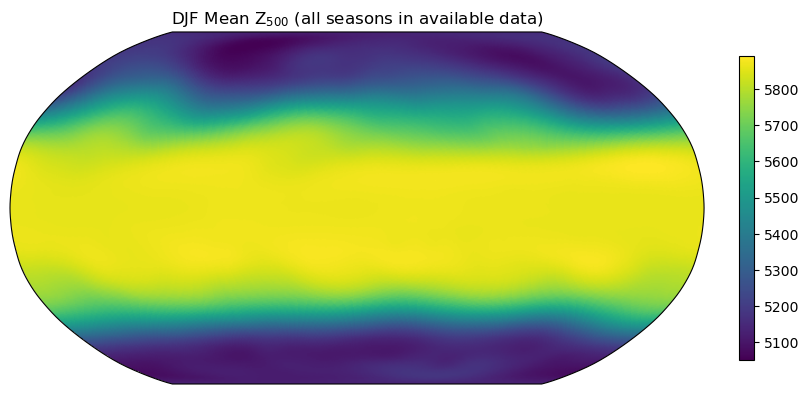

CPU times: user 6.31 s, sys: 1.72 s, total: 8.03 s
Wall time: 9.43 s


In [6]:
%%time
# Select Z500
z500 = ds.zg.sel(plev=500)

# Keep only DJF times (Dec–Jan–Feb across all years)
z500_djf = z500.where(z500['time'].dt.season == 'DJF', drop=True)

# Time-mean across *all* available DJF points
z500_djf_mean = z500_djf.mean(dim='time')

# Plot
worldmap(z500_djf_mean)
plt.title("DJF Mean Z$_{500}$ (all seasons in available data)")
plt.show()


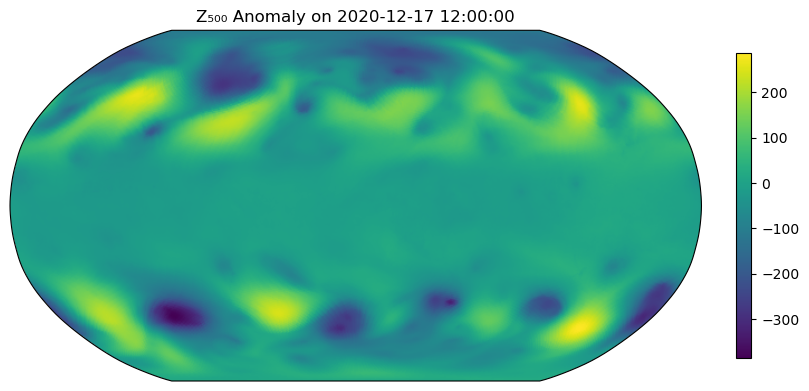

In [7]:
import numpy as np

# 1. Fix the random seed for reproducibility
np.random.seed(42)

# 2. Select Z500 and isolate all DJF times
z500 = ds.zg.sel(plev=500)
z500_djf = z500.where(z500['time'].dt.season == 'DJF', drop=True)

# 3. Compute the DJF climatology
z500_djf_mean = z500_djf.mean(dim='time')

# 4. Pick a random DJF time index
n_times = z500_djf.sizes['time']
rand_idx = np.random.randint(n_times)
rand_time = z500_djf['time'][rand_idx].values
# print(rand_time)

# 5. Extract the field at that random time
z500_rand = ds.zg.sel(plev=500, time=rand_time)

# 6. Compute the anomaly (random snapshot minus climatology)
anomaly = z500_rand - z500_djf_mean

# 7. Plot it
worldmap(anomaly)
plt.title(f"Z₅₀₀ Anomaly on {rand_time}")
plt.show()


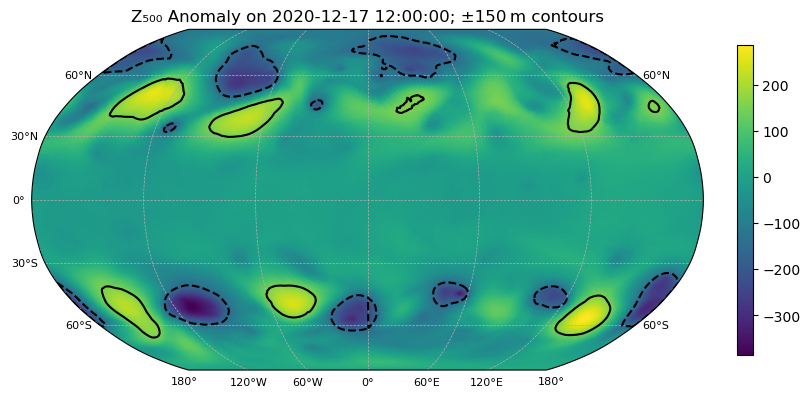

In [9]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs

# 1. Fix the random seed
np.random.seed(42)

# 2. Select and filter to DJF @500 hPa
z500     = ds.zg.sel(plev=500)
z500_djf = z500.where(z500['time'].dt.season == 'DJF', drop=True)

# 3. Climatology
clim     = z500_djf.mean(dim='time')

# 4. Random pick
n_times  = z500_djf.sizes['time']
idx      = np.random.randint(n_times)
rand_time= z500_djf['time'][idx].values
rand_pd  = rand_time

# 5. Snapshot & anomaly
snap     = ds.zg.sel(plev=500, time=rand_time)
anomaly  = snap - clim

# 6. Plot base map
worldmap(anomaly)
ax = plt.gca()

# 7. Add coastlines
# ax.coastlines(resolution='110m', linewidth=1)

# 8. Add lat/lon gridlines with labels
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    linestyle='--'
)
gl.top_labels   = False
gl.right_labels = False
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# 9. Overlay ±150 m contours
lon = anomaly['lon'].values
lat = anomaly['lat'].values
data = anomaly.values

ax.tricontour(
    lon, lat, data,
    levels=[150],
    colors='k',
    linestyles='solid',
    transform=ccrs.PlateCarree()
)
ax.tricontour(
    lon, lat, data,
    levels=[-150],
    colors='k',
    linestyles='dashed',
    transform=ccrs.PlateCarree()
)

# 10. Title and show
plt.title(f"Z₅₀₀ Anomaly on {rand_pd}; ±150 m contours")
plt.show()


Weighted centroid: For each retained region, computes

$$
(\bar{\lambda}, \bar{\phi})=\frac{\sum_i w_i\left(\lambda_i, \phi_i\right)}{\sum_i w_i}, \quad w_i=\mid z_{500, i}-\text { sign } \times \text { level } \mid
$$

and plots a black $\times$ (positive anomalies) or white $\times$ (negative anomalies).

In [10]:
import numpy as np
import scipy.ndimage as ndi
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

def plot_contours(anom, level=150, min_box_deg=1.0,
                  filter_small=True, mark_centroids=True, ax=None):
    """
    Draw ±level-m contours on a PlateCarree map, optionally
    1) skipping features whose bounding box is < min_box_deg × min_box_deg
    2) marking the mass-weighted centroid of each retained region
    """
    if ax is None:
        ax = plt.gca()

    # --- prepare lat/lon grids (assumes 2-D lon/lat coords) ------------------
    lon2d, lat2d = np.meshgrid(anom['lon'].values, anom['lat'].values)
    data = anom.values

    # logical masks for the two thresholds
    pos_mask = data >=  level
    neg_mask = data <= -level

    # convenient helper -------------------------------------------------------
    def _regions_and_centroids(mask, sign):
        """
        Connected-component labelling + centroid computation.
        sign = +1 (positive) or –1 (negative) merely routes the plotting style.
        """
        if not mask.any():
            return []

        # 4-connected regions on the 2-D grid
        lbl, nreg = ndi.label(mask)
        objs = []
        for n in range(1, nreg + 1):
            y, x = np.where(lbl == n)
            lats = lat2d[y, x]
            lons = lon2d[y, x]

            # bounding-box filter
            if filter_small:
                if (lats.ptp() < min_box_deg) and (lons.ptp() < min_box_deg):
                    continue

            # weighted centroid: weight = |anomaly – sign*level|
            w = np.abs(data[y, x] - sign * level)
            w_sum = w.sum()
            if w_sum == 0:      # numerical safety
                continue
            yc = (w * lats).sum() / w_sum
            xc = (w * lons).sum() / w_sum
            objs.append((y, x, yc, xc))
        return objs

    # --- process positive & negative families --------------------------------
    for mask, sign, ls in [(pos_mask, +1, 'solid'),
                           (neg_mask, -1, 'dashed')]:

        objs = _regions_and_centroids(mask, sign)
        if not objs:
            continue

        # stack all points we decided to keep into one big contour call --------
        for y, x, yc, xc in objs:
            ax.tricontour(lon2d[y, x], lat2d[y, x], data[y, x],
                          levels=[sign * level],
                          colors='k', linestyles=ls,
                          transform=ccrs.PlateCarree())

            if mark_centroids:
                ax.plot(xc, yc,
                        marker='x',
                        markersize=6,
                        markeredgewidth=1.5,
                        color='k' if sign == +1 else 'white',
                        transform=ccrs.PlateCarree())

    # make sure white crosses float above everything
    ax.set_zorder(2)


In [ ]:
plot_contours(anomaly,
              level         = 150,
              min_box_deg    = 1.0,
              filter_small   = True,      # flip to False to keep every blob
              mark_centroids = True,      # flip to False to hide × markers
              ax             = ax)


In [15]:
# shift 0–360 → −180…+180
ds_500 = ds_500.assign_coords({
    'lon': ((ds_500['lon'] + 180) % 360) - 180
})

# reorder the 'cell' axis so lon increases monotonically
ds_500 = ds_500.sortby('lon')



In [16]:
ds_500

<xarray.Dataset> Size: 325GB
Dimensions:  (time: 3560, cell: 196608, pfull: 79)
Coordinates:
  * pfull    (pfull) float32 316B 4.514 8.301 12.45 16.74 ... 989.5 994.3 998.3
    plev     float32 4B 500.0
  * time     (time) object 28kB 2019-10-20 03:00:00 ... 2021-01-07 00:00:00
    crs      int64 8B 0
  * cell     (cell) int64 2MB 98304 98307 98316 98319 ... 114681 114686 152917
    lat      (cell) float64 2MB -41.41 -40.62 -39.84 ... 40.23 41.01 -41.81
    lon      (cell) float64 2MB -180.0 -180.0 -180.0 ... 179.6 179.6 179.6
Data variables: (12/38)
    clivi    (time, cell) float32 3GB ...
    clt      (time, cell) float32 3GB ...
    clwvi    (time, cell) float32 3GB ...
    hflsd    (time, cell) float32 3GB ...
    hfssd    (time, cell) float32 3GB ...
    hur      (time, cell) float32 3GB ...
    ...       ...
    uas      (time, cell) float32 3GB ...
    va       (time, cell) float32 3GB ...
    vas      (time, cell) float32 3GB ...
    wa       (time, cell) float32 3GB ...
    wap      (time, cell) float32 3GB ...
    zg       (time, cell) float32 3GB ...

In [18]:
# 3) Boolean‐mask to keep only the cells in your box (e.g. lon ∈ [–100,40], lat ∈ [0,90])
mask = (
    (ds_500.lon >= -100) & (ds_500.lon <= 40) &
    (ds_500.lat >=   0) & (ds_500.lat <= 90)
)
ds_box = ds_500.isel(cell=mask)

# confirm
print(ds_box.lon.min().item(), ds_box.lon.max().item(),
      ds_box.lat.min().item(), ds_box.lat.max().item())

-99.9590163934426 39.96000000000001 0.0 89.63451650477154


In [20]:
ds_box['zg']

<xarray.DataArray 'zg' (time: 3560, cell: 38314)> Size: 546MB
[136397840 values with dtype=float32]
Coordinates:
    plev     float32 4B 500.0
  * time     (time) object 28kB 2019-10-20 03:00:00 ... 2021-01-07 00:00:00
    crs      int64 8B 0
  * cell     (cell) int64 307kB 38670 38799 40218 40347 ... 12816 9717 9668
    lat      (cell) float64 307kB 44.2 47.75 51.26 54.72 ... 50.09 46.57 43.01
    lon      (cell) float64 307kB -99.96 -99.96 -99.95 ... 39.95 39.96 39.96

CPU times: user 1.35 s, sys: 431 ms, total: 1.78 s
Wall time: 1.84 s


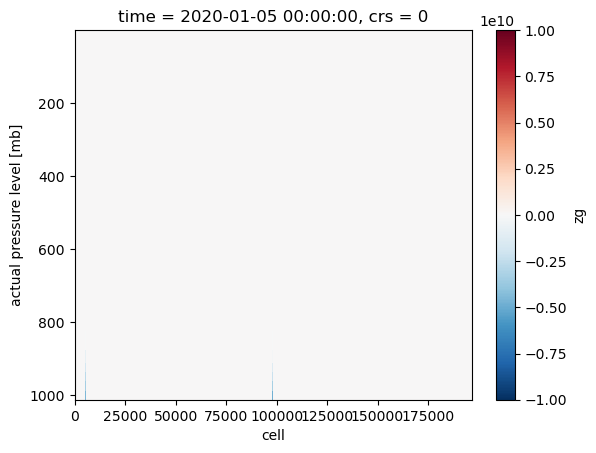

In [22]:
%%time

# snapshot
var='zg'
tm='2020-01-05'
tmp=ds[var].sel(time=tm)[0]

tmp

# zonal mean 
zm = (
    tmp
    .groupby("plev")
    .mean()
).compute()

zm.plot()
plt.gca().invert_yaxis()